---
# Évaluation des modèles de classification
---

<center><img src="./img/mlprocess_4.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

Dans cette séquence, nous allons évaluer, à l'aide des différentes métriques vues dans le cours, différents modèles de classification.

Nous allons ainsi repartir de l'exemple simple vu dans le module de classification ([`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)) et établir un modèle de référence auquel on va se comparer par la suite. Dans un second temps, nous allons évaluer le modèle de votre choix sur cet ensemble. 

Dans la prochaine séquence, nous passerons à des données réelles (donc multiclasses).

Importons d'abord les librairies nécessaires.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, make_moons, make_blobs
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, fbeta_score, log_loss, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, matthews_corrcoef
from imblearn.datasets import make_imbalance
import matplotlib.pylab as pylab
from matplotlib.colors import ListedColormap
import itertools
from matplotlib import pyplot

In [2]:
fg = (8,6)
cm_points = ListedColormap(['#FF0000','#FFFFFF', '#00FF00','#000000', '#0000FF'])
cm = plt.cm.viridis
params = {'figure.titlesize': 'xx-large',
          'font.size': '12',
          'text.color': 'k',
          'figure.figsize': fg,
         }
pylab.rcParams.update(params)

Nous allons utiliser la même fonction d'affichage que dans la module de présentation des algorithmes de classification.

In [3]:
def plotClassifierOnData(name,clf,data,threshold=None):
    """
    Pour Afficher les résultat d'un classificateur sur un dataset
    name : Le titre du graphique
    clf : Le classificateur à utiliser
    data : les données à utiliser
    i : Le ième graphique sur n à afficher (pour afficher 3 graphiques par ligne)
    n : Le nombre total de graphiques à afficher
    multi: Spécifie si l'on affiche juste la frontière de décision (True) ou 
           le score/probabilité de chaque point de l'espace, car on ne peut afficher le score en multiclasse.
    """
    
    f = plt.figure(figsize=fg)
    
    # Préparation rapide des données : normalisation des données et calcul des bornes 
    X, y = data
    
    # Visualisation des régions
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    ax = plt.subplot(1,1,1)
    
    # Pour afficher les frontières de décision on va choisir une couleur pour 
    # chacun des points x,y du grillage [x_min, x_max]x[y_min, y_max].

    # Si on est en multiclasse (2 ou +), on affiche juste les frontières
    if threshold:
         Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) > threshold
    else:# Sinon on peut afficher le gradient du score
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # On affiche le grillage de décision.
    Z = Z.reshape(xx.shape)
    test = ax.contourf(xx, yy, Z, 100, cmap=cm, alpha=.8)

    # On affiche la légende
    cbar = plt.colorbar(test)
    cbar.ax.set_title('score')
    
    # On affiche les points d'entraînement.
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_points,
               edgecolors='k',s=100)


    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.set_title(name,fontsize=22)
    
    #plt.tight_layout()
    plt.show()   

Initialisons l'ensemble de données avec significativement plus de points de manière à créer une forme de déséquilibre à l'intérieur. 

N'hésitez pas à jouer sur ce déséquilibre et sur le bruit du dataset afin d'en voir l'effet sur la suite de l'exemple !


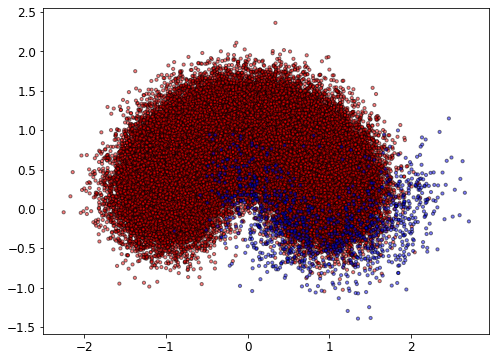

In [4]:
# Paramètres du dataset
N = 100000;
ratio_debalancement = 0.01;
bruit=0.3

# Générations des données
X, y = make_moons(n_samples=10*N, shuffle=True, noise=bruit, random_state=42)
X, y =  make_imbalance(X,y, sampling_strategy={0: int(N*(1-ratio_debalancement)), 1: int(N*ratio_debalancement)})

# Visualisation
f = plt.figure() 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_points, edgecolor='k', s=10, alpha=.5)
plt.show()

## Séparation des données train/validation/test 40% / 30% / 30%

In [5]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.42857, stratify=y_)

## Établir la baseline de performance

Pour ce modèle de référence, nous allons utiliser un classificateur stupide prédisant toujours la classe majoritaire : [`DummyClassifier(strategy='most_frequent',...)`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)


In [6]:
# baseline_clf = ...

Et on en mesure la précision; elle servira de borne inférieure sur la classification :

In [7]:
y_pred_train = baseline_clf.predict(X_train)
acc_baseline = accuracy_score(y_pred_train, y_train)
print('Performance baseline: ', acc_baseline)

NameError: name 'baseline_clf' is not defined

## Entraînement d'un classificateur

À partir d'ici, vous pouvez choisir n'importe quel classificateur et l'entraîner comme nous l'avons fait dans le module 3.
Nous l'évaluerons par la suite avec sa matrice de confusion, au lieu d'utiliser simplement l'exactitude, afin d'en tirer le plus de métriques possible.

Vous trouverez un rappel des classificateurs offerts dans [Scikit-Learn ici](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).


In [ ]:
# clf = ...

## Calcul de la matrice de confusion avec l'ensemble de validation

À partir de notre classificateur entraîné, il est possible de déterminer quelle probabilité il assigne à la classe `1` (ou la classe `0`) en utilisant la fonction `predict_proba()` de la plupart des classificateurs de Scikit-Learn. Un exemple vous est donné ci-dessous.

Une fois la probabilité calculée, il est possible de se ramener à une classe en choisissant un seuil. Dans l'exemple ci-dessous nous avons utilisé $0.5$, qui est la valeur de seuil par défaut.


In [ ]:
threshold = .5

y_val_pred_proba = clf.predict_proba(X_val)[:,1]
y_val_pred_label = y_val_pred_proba > threshold

Avec le seuil choisi, on peut maintenant calculer la matrice de confusion de notre classificateur en utilisant la fonction [`plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)

In [ ]:
f = plt.figure(figsize=(4,4))
cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
plot_confusion_matrix(clf, X_val, y_val, values_format='1')

et aussi calculer l'exactitude sur l'ensemble de validation avec la fonction [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [ ]:
accuracy_score(y_val, y_val_pred_label)

Cependant, est-ce que le choix du seuil à $0.5$ était le meilleur ? Peut-on choisir un autre seuil permettant de mieux généraliser sur l'ensemble de validation ? 

Essayez de trouver un meilleur seuil, soit par essais et erreurs, soit en fusionnant les cellules précédentes en une seule et en utilisant un peu de programmation pour déterminer le seuil optimal. 

N'hésitez pas à échanger sur le forum à ce sujet !


## Calculer la courbe ROC et l'aire sous celle-ci (AUC)

Vous avez vu dans la partie théorique qu'il existe en fait une manière de tester tous les seuils d'un coup avec la [courbe ROC](https://fr.wikipedia.org/wiki/Courbe_ROC) ([`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) dans Scikit-Learn). C'est ce que nous allons faire maintenant.


In [ ]:
y_proba_val = clf.predict_proba(X_val)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_proba_val)

fig, ax = plt.subplots()
plot_roc_curve(clf, X_val, y_val, name='ROC curve', ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

In [ ]:
roc_auc_score(y_val, y_proba_val)

In [ ]:
thresholds[np.argmax(-fpr_rf + tpr_rf)]

In [ ]:
plotClassifierOnData("clf",clf,(X_val, y_val))

## Calculer la courbe de précision/rappel

Il est également possible de le faire avec la courbe de [précision/rappel](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel) ([`precision_recall_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) dans Scikit-Learn).

On peut ainsi calculer tous les précisions et rappels possibles selon le seuil choisi : 


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, y_proba_val)

ou bien afficher directement la courbe de précision/rappel : 

In [ ]:
plot_precision_recall_curve(clf, X_val, y_val)

Dans certaines applications, le rappel est beaucoup plus important que la précision. Par exemple, lorsqu’il s’agit de trouver les courriels qui ne sont pas des pourriels, il est très important de trouver tous les courriels qui ne sont pas des pourriels ; il est cependant moins grave que certains pourriels survivent au filtrage.

Le contraire est parfois vrai. Supposons qu’on doive attribuer à des documents des mots-clés pour faciliter la recherche. On peut mesurer la qualité d’exécution de cette tâche en fonction du rappel (est-ce qu’on a trouvé tous les mots-clés qui s’appliquent ?) et de la précision (est-ce que tous les mots-clés attribués sont pertinents ?). Dans ce cas, la précision n’est pas très importante, mais on souhaite que tous les documents puissent être traités.

Comment choisir le meilleur compromis lorsque la précision et le rappel sont pratiquement d’égales importances ? Une des méthodes utilisées est de maximiser la moyenne harmonique de la précision et du rappel : $\frac{r+p}{2rp}$. On appelle cette moyenne le score F.


## Évaluer le [F-score](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel#F-mesure) pour différents seuils

Pour rappel donc, la mesure qui combine la précision et le rappel est leur moyenne harmonique, nommée F-mesure ou F-score :
$F=2\cdot \frac{({\text{précision}}\cdot {\text{rappel}})}{({\text{précision}}+{\text{rappel}})}$

Elle est également connue sous le nom de mesure $F_1$, car précision et rappel sont pondérés de façon égale. Il s'agit d'un cas particulier de la mesure générale $F_{\beta}$ (pour des valeurs réelles positives de $\beta$ : 

$F_{\beta }={\frac {(1+\beta ^{2})\cdot ({\text{précision}}\cdot {\text{rappel}})}{(\beta ^{2}\cdot {\text{précision}}+{\text{rappel}})}}$

Calculons donc maintenant le score F pour tous les seuils possibles. N'hésitez pas à voir l'impact de $\beta$ sur la courbe résultat.


In [ ]:
beta = 1

M = 1000
thresholds = np.linspace(-0.1, 1.1, M)
score = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_proba_val > thresholds[i])*1.0
    score[i] = fbeta_score(y_val, y_pred_, beta)

In [ ]:
f = plt.figure()

plt.plot(thresholds, score)
plt.xlabel('Threshold')
plt.ylabel('F{0}-Score'.format(beta))
plt.title('F{0}-Score'.format(beta))
plt.show()

Trouvons le seuil maximisant la mesure de F choisie : 

In [ ]:
thresholds[np.argmax(score)]

## Calculer le [coefficient de corrélation de Mathews (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)

Un des défauts du F-score est sa faiblesse face aux données déséquilibrées. En voici un exemple donné sur la page de Wikipedia ci-dessus : 

Comme expliqué par Davide Chicco dans son article "Ten quick tips for machine learning in computational biology" (BioData Mining, 2017) et par Giuseppe Jurman dans son article "The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation" (BMC Genomics, 2020), le coefficient de corrélation de Matthews est plus instructif que le score $F_1$ et plus précis dans l'évaluation des problèmes de classification binaire, car il tient compte des rapports d'équilibre des quatre catégories de la matrice de confusion (vrais positifs, vrais négatifs, faux positifs, faux négatifs).

Ainsi, afin d'avoir une compréhension globale d'une prédiction, si vous décidez de tirer profit des scores statistiques communs, tels que l'exactitude et le score $F_1$.

${\text{accuracy}}={\frac {TP+TN}{TP+TN+FP+FN}}$ (Équation 1, précision : la pire valeur = 0 ; la meilleure valeur = 1)

${\text{F1 score}}={\frac {2TP}{2TP+FP+FN}}$ (Équation 2, score F1 : la pire valeur = 0 ; la meilleure valeur = 1)

Toutefois, même si la précision et le score $F_1$ sont largement utilisés en statistique, ils peuvent tous deux être trompeurs, car ils ne tiennent pas pleinement compte de la taille des quatre classes de la matrice de confusion dans le calcul du score final.

Supposons, par exemple, que vous ayez un ensemble de validation très déséquilibré composé de 100 éléments, dont 95 sont des éléments positifs et seulement 5 sont des éléments négatifs. Et supposons aussi que vous ayez fait quelques erreurs dans la conception et l'apprentissage de votre classificateur d'apprentissage machine, et que vous ayez maintenant un algorithme qui prédit toujours le positif. Imaginez que vous n'êtes pas conscient de ce problème.

En appliquant votre seul prédicteur positif à votre ensemble de validation déséquilibré, vous obtenez donc des valeurs pour les catégories de la matrice de confusion :

TP = 95, FP = 5 ; TN = 0, FN = 0.

Ces valeurs conduisent aux scores de performance suivants : exactitude = 95%, et score $F_1$ = 97,44%. En lisant ces scores trop optimistes, vous serez alors très heureux et penserez que votre algorithme d'apprentissage automatique fait un excellent travail. Il est évident que vous feriez fausse route.

Au contraire, pour éviter ce piège, il existe un autre score de performance que vous pouvez exploiter : le coefficient de corrélation de Matthews (MCC).

$ \text{MCC}= \frac{TP\times TN-FP\times FN}{\sqrt {(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$ (Équation 3, MCC : la pire valeur = -1 ; la meilleure valeur = +1).

En considérant la proportion de chaque classe de la matrice de confusion dans sa formule, son score n'est élevé que si votre classificateur obtient de bons résultats à la fois sur les éléments négatifs et positifs.

Dans l'exemple ci-dessus, le score MCC serait *indéfini* (puisque TN et FN seraient 0, donc le dénominateur de l'équation 3 serait 0). En vérifiant cette valeur, au lieu de la précision et de du score $F_1$, vous pourriez alors remarquer que votre classificateur va dans la mauvaise direction, et vous prendriez conscience qu'il y a des problèmes à résoudre avant de poursuivre.

Prenons cet autre exemple. Vous avez effectué une classification sur le même ensemble de données, ce qui a donné les valeurs suivantes pour les catégories de la matrice de confusion :

TP = 90, FP = 4 ; TN = 1, FN = 5.

Dans cet exemple, le classificateur a obtenu de bons résultats en classant les cas positifs, mais n'a pas pu reconnaître correctement les éléments de données négatifs. Là encore, le score $F_1$ et les scores d'exactitude obtenus seraient extrêmement élevés : exactitude = 91%, et score $F_1$ = 95,24%. Comme dans le cas précédent, si un chercheur n'analysait que ces deux indicateurs de score, sans tenir compte du MCC, il penserait à tort que l'algorithme est assez performant dans sa tâche, et aurait l'illusion de réussir.

D'autre part, la vérification du coefficient de corrélation de Matthews serait une fois de plus essentielle. Dans cet exemple, la valeur du MCC serait de 0,14 (équation 3), ce qui indique que l'algorithme fonctionne de la même manière que la conjecture aléatoire. Agissant comme une alarme, le MCC serait en mesure d'informer le praticien de la fouille des données (data mining) que son modèle statistique est peu performant.

Pour ces raisons, nous encourageons vivement à évaluer les performances de chaque test par le biais du coefficient de corrélation de Matthews (MCC), au lieu de la précision et du score $F_1$, pour tout problème de classification binaire.
    - Davide Chicco, "Ten quick tips for machine learning in computational biology" (BioData Mining, 2017)

Notez que le score $F_1$ dépend de la classe qui est définie positive. Dans le premier exemple ci-dessus, le score $F_1$ est élevé parce que la classe majoritaire est définie positive. L'inversion des classes positives et négatives donne la matrice de confusion suivante :

TP = 0, FP = 0 ; TN = 5, FN = 95

Cela donne un score de $F_1 = 0\%$.

Le MCC ne dépend pas de la classe positive, qui a l'avantage par rapport à la note $F_1$ d'éviter de définir incorrectement la classe positive. 

Calculons-le maintenant pour notre exemple d'origine.


In [ ]:
M = 1000
mcc = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_proba_val > thresholds[i])*1.0
    mcc[i] = matthews_corrcoef(y_val, y_pred_)

In [ ]:
f = plt.figure()

plt.plot(thresholds, mcc)
plt.xlabel('Threshold')
plt.ylabel('MCC')
plt.title('MCC')
plt.show()

In [ ]:
thresholds[np.argmax(mcc)]

## Calcul de la métrique d'[entropie croisée](https://fr.wikipedia.org/wiki/Entropie_crois%C3%A9e)

La perte d'entropie croisée, ou perte logarithmique ([`log_loss`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)) mesure la performance d'un modèle de classification dont la sortie est une valeur de probabilité comprise entre 0 et 1. La perte d'entropie croisée augmente à mesure que la probabilité prévue s'écarte de l'étiquette réelle. Ainsi, prédire une probabilité de 0,012 lorsque l'étiquette d'observation réelle est de 1 serait mauvais et entraînerait une valeur de perte élevée. Un modèle parfait aurait une perte logarithmique de 0.

Dans le cadre de notre exemple : 


In [ ]:
log_loss(y_val, y_proba_val)

## Calcul de la métrique d'utilité

La métrique d'utilité est considérée comme la plus flexible d'entre toutes, car elle permet d'évaluer précisément le poids de chaque type d'erreur et de récompenser, comme voulu, chaque type de réussite. Vous en avez vu des exemples dans la capsule théorique. Je vous invite à jouer avec les valeurs ci-dessous pour voir l'impact sur la métrique de votre classificateur. Par défaut, celui-ci est optimisé sur l'exactitude lorsque vous ne spécifiez pas de fonction de perte lors de l'entraînement.


In [ ]:
FP_loss = -0
FN_loss = -0
TP_reward = 1
TN_reward = 1
utility = lambda cnf_matrix: cnf_matrix[1,1]*TP_reward + cnf_matrix[0,0]*TN_reward + cnf_matrix[1,0]*FN_loss + cnf_matrix[0,1]*FP_loss

In [ ]:
M = 100
thresholds = np.linspace(-0.1, 1.1, M)
score = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_proba_val > thresholds[i])*1.0
    cnf_matrix = confusion_matrix(y_val, y_pred_)
    score[i] = utility(cnf_matrix)

In [ ]:
f = plt.figure()
pyplot.grid(True)
pyplot.ion()
pyplot.yscale('symlog')
pyplot.plot(thresholds, score)
pyplot.xlabel('Threshold')
pyplot.ylabel('utility')
pyplot.title('Utility-based cost')
pyplot.ylim(29000, 30000)
pyplot.show()

In [ ]:
thresholds[np.argmax(score)]

Vous avez maintenant plusieurs métriques dans votre boîte à outils. Testez différents modèles avec différentes fonctions de pertes afin de voir comment ils se comportent en fonction des métriques potentiellement non différentiables.